Sacar los puntos caracteristicos de la imagen, sacar la matriz y calcularle la inversa, Usar SIFT para encontrar los puntos caracteristicos

1. Cargar imágenes
2. Extraer SIFT keypoints y descriptores
3. Hacer matching (BF o FLANN)
4. Elegir las mejores N correspondencias
5. Construir la matriz A
6. Resolver Ah = 0 con SVD → obtener H
7. Warpear img1 hacia img2 usando H
8. Crear canvas amplio
9. Pegar imagen warp
10. Pegar imagen 2 encima
11. Hacer blending
12. Mostrar resultado final


In [334]:
import cv2
import numpy as np
import random
import os
import math
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab.patches import cv2_imshow

In [335]:

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [336]:
img1 = cv2.imread('cerro2.png')
img2 = cv2.imread('cerro1.png')

print("Imágenes cargadas:")
print(f"Imagen 1: {img1.shape}")
print(f"Imagen 2: {img2.shape}")

h1, w1 = img1.shape[:2]
h2, w2 = img2.shape[:2]

Imágenes cargadas:
Imagen 1: (442, 720, 3)
Imagen 2: (442, 720, 3)


In [337]:
sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

print("Keypoints 1:", len(kp1))
print("Keypoints 2:", len(kp2))

# Normalizar descriptores
des1 = des1 / (np.linalg.norm(des1, axis=1, keepdims=True) + 1e-8)
des2 = des2 / (np.linalg.norm(des2, axis=1, keepdims=True) + 1e-8)


Keypoints 1: 1369
Keypoints 2: 1003


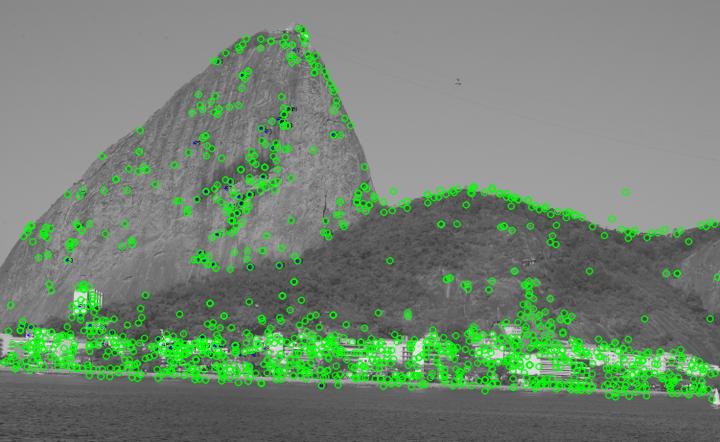

In [338]:
img_kp = cv2.drawKeypoints(
    img1,
    kp1,
    None,
    color=(0,255,0),
)

cv2_imshow(img_kp)

In [339]:
matches = []

for i in range(len(des1)):
    # distancias a todos los descriptores de la segunda imagen
    dists = np.linalg.norm(des2 - des1[i], axis=1)

    # ordenamos para aplicar ratio test
    idx = np.argsort(dists)
    best = idx[0]
    second = idx[1]

    # ratio test (parámetro típico 0.75)
    if dists[best] < 0.75 * dists[second]:
        matches.append((i, best))


In [340]:
def compute_H(pairs):
    A = []
    for (i, j) in pairs:
        x, y = kp1[i].pt
        u, v = kp2[j].pt
        A.append([-x, -y, -1, 0, 0, 0, x*u, y*u, u])
        A.append([0, 0, 0, -x, -y, -1, x*v, y*v, v])
    A = np.array(A)
    _, _, Vt = np.linalg.svd(A)
    H = Vt[-1].reshape(3, 3)
    return H / H[2, 2]

def ransac_homography(matches, iterations=2000, threshold=5):
    best_inliers = []
    best_H = None

    for _ in range(iterations):
        # tomar 4 matches aleatorios
        sample = random.sample(matches, 4)

        # construir una homografía
        H = compute_H(sample)

        inliers = []
        for (i, j) in matches:
            x, y = kp1[i].pt
            p = np.array([x, y, 1])
            u_pred, v_pred, w = H @ p
            u_pred /= w
            v_pred /= w
            u, v = kp2[j].pt

            if (u - u_pred)**2 + (v - v_pred)**2 < threshold**2:
                inliers.append((i, j))

        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_H = H

    print("Inliers:", len(best_inliers))
    return compute_H(best_inliers)


In [341]:
def warp_perspective_manual(img, H, out_w, out_h):
    H_inv = np.linalg.inv(H)
    warped = np.zeros((out_h, out_w, 3), dtype=np.uint8)

    for y in range(out_h):
        for x in range(out_w):

            # punto destino (x, y)
            p = np.array([x, y, 1])

            # aplicamos la transformada inversa
            src = H_inv @ p
            xs = src[0] / src[2]
            ys = src[1] / src[2]

            # si el punto está dentro de la imagen original
            xs = int(xs)
            ys = int(ys)

            if 0 <= xs < img.shape[1] and 0 <= ys < img.shape[0]:
                warped[y, x] = img[ys, xs]

    return warped

H = ransac_homography(matches)

Inliers: 457


In [342]:
canvas_w = img1.shape[1] + img2.shape[1]
canvas_h = max(img1.shape[0], img2.shape[0])

warped1 = warp_perspective_manual(img1, H, canvas_w, canvas_h)
panorama = warped1.copy()
panorama[:img2.shape[0], :img2.shape[1]] = img2

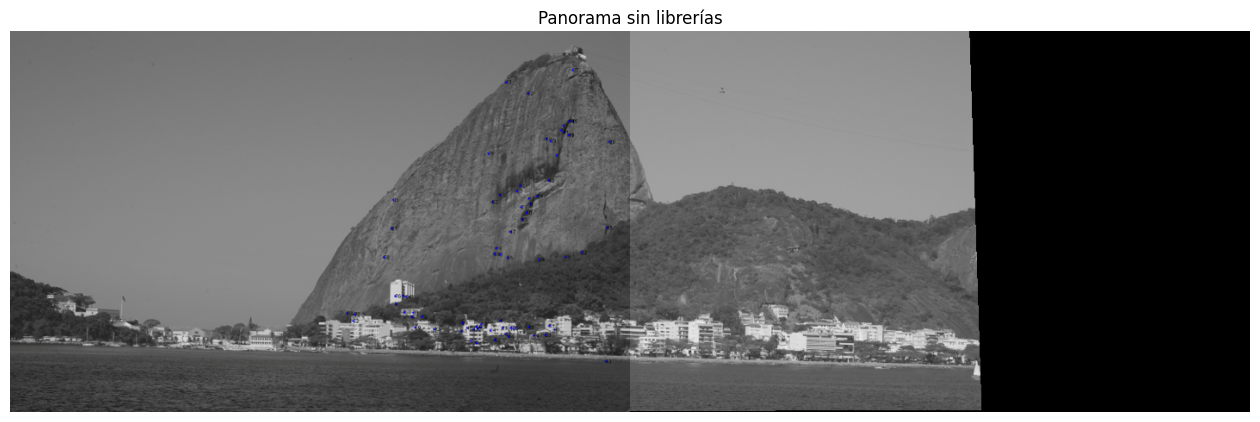

In [343]:
plt.figure(figsize=(16,8))
plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
plt.title("Panorama sin librerías")
plt.axis("off")
plt.show()

Matches buenos: 464


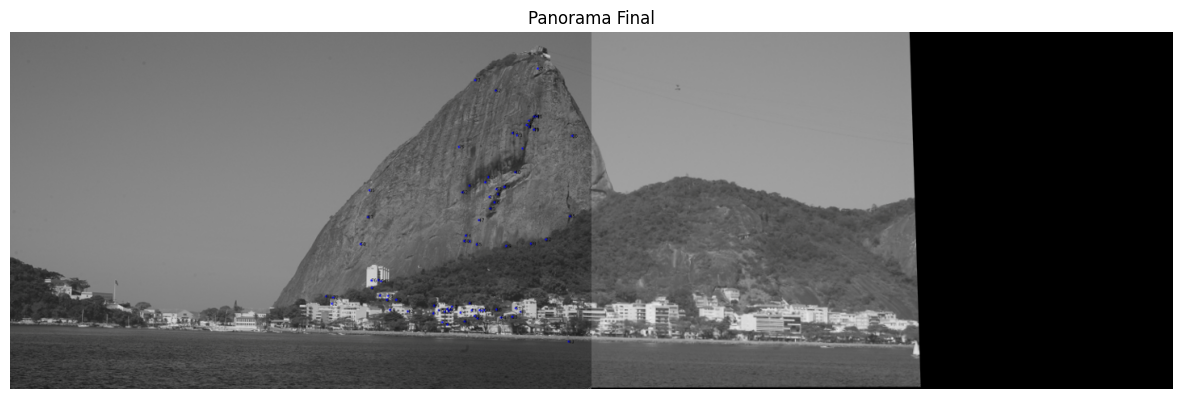

In [344]:
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
%matplotlib inline

# SIFT
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

# Matcher FLANN
index_params = dict(algorithm=1, trees=5)
search_params = dict()

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Ratio test
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)

print("Matches buenos:", len(good))

# Necesitamos al menos 4
if len(good) < 4:
    print("Muy pocos matches, no se puede calcular H")
else:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

    # Homografía
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)

    # Warpeo de img1 hacia img2
    h2, w2, _ = img2.shape
    h1, w1, _ = img1.shape

    # Tamaño del lienzo (ancho = suma de anchos)
    pano_width = w1 + w2
    pano_height = max(h1, h2)

    # Warpear img1 al lienzo
    warped_img1 = cv2.warpPerspective(img1, H, (pano_width, pano_height))

    # Crear una copia del lienzo
    panorama = warped_img1.copy()

    # Colocar img2 en su posición
    panorama[0:h2, 0:w2] = img2

    # Mostrar resultado
    plt.figure(figsize=(15,8))
    plt.title("Panorama Final")
    plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()
